Purpose of this notebook is to use LORA (aka Low Rank Adaptation method) and finetune

In [1]:
# !python -m pip install -q datasets peft evaluate

In [2]:
# !python -m pip uninstall -y pyarrow datasets ibis-framework

In [3]:
# !python -m pip install pyarrow>=15.0.0 datasets peft evaluate

In [4]:
# !python -m pip show pyarrow datasets

In [5]:
# !python -m pip install pyarrow>=15.0.0 datasets peft evaluate

In [6]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (AutoTokenizer,
                         AutoConfig,
                         AutoModelForSequenceClassification,
                         DataCollatorWithPadding,
                         TrainingArguments,
                         Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/home/jupyter/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'mps'
print(device)

cuda


#### Base Model (mobileBERT)

In [8]:
model_checkpoint = 'google/mobilebert-uncased'
id2label = {0: 'information_intent',
            1: 'yelp_intent',
            2: 'navigation_intent',
            3: 'travel_intent',
            4: 'purchase_intent',
            5: 'weather_intent',
            6: 'translation_intent',
            7: 'unknown'}
label2id = {label:id for id,label in id2label.items()}


# generate classification model from model chckpoints
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=8,
    id2label=id2label,
    label2id=label2id
)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Load dataset

In [9]:
df = pd.read_csv("data/marco_train_v4.csv")
print(len(df))
print(df['target'].value_counts())
df.head(10)

176568
target
information_intent    117561
yelp_intent            28489
weather_intent         13271
navigation_intent      11532
purchase_intent         2220
translation_intent      2159
travel_intent           1320
unknown                   16
Name: count, dtype: int64


,sequence,target
0,cost of hardwood flooring installed,yelp_intent
1,cost of full mouth dental implants,yelp_intent
2,cost of bmw suv,information_intent
3,how much money do writers make,information_intent
4,average temperature shanghai,weather_intent
5,walt disney fast pass cost,information_intent
6,villanova tuition cost,information_intent
7,cost of floor to ceiling windows,yelp_intent
8,cost of deka batteries,information_intent
9,current stock price of micron,information_intent


count    176568.000000
mean         29.835027
std          10.651826
min           6.000000
10%          18.000000
20%          21.000000
25%          22.000000
30%          24.000000
40%          26.000000
50%          29.000000
60%          31.000000
70%          34.000000
75%          36.000000
80%          37.000000
90%          43.000000
95%          48.000000
98%          55.000000
99%          61.000000
99.5%        69.000000
99.8%        83.000000
99.9%        95.000000
max         193.000000
Name: sequence, dtype: float64


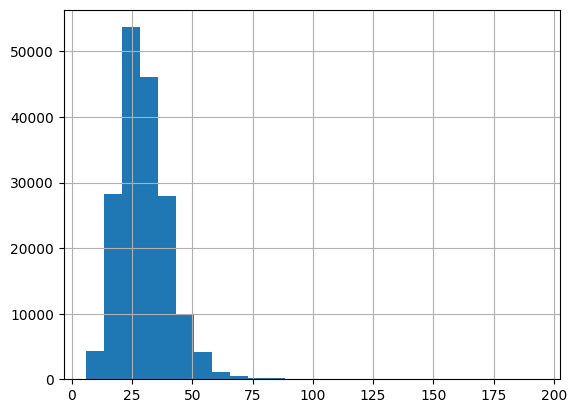

In [10]:
print(df['sequence'].apply(len).describe(percentiles=[.1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9, .95, .98, .99, .995, .998, .999]))
df['sequence'].apply(len).hist(bins=25);

In [11]:
pd.set_option('display.max_colwidth', 100)
df.loc[df['sequence'].apply(lambda text: len(text) > 64)]

,sequence,target
756,what is the difference between marginal cost and marginal revenue,information_intent
1165,price of four day ticket for florida resident to disney world in florida,information_intent
21766,Top stores offering deals on Asics running shoesWhere to buy {gifts} online?,purchase_intent
21776,Top stores offering deals on Bauer hockey skatesWhere to buy {gifts} online?,purchase_intent
21796,Compare Hoover carpet cleaner with Hoover carpet cleaner for best value,purchase_intent
...,...,...
176151,__________ is the process of hiring another organization to perform a service.,yelp_intent
176155,requirements to be awarded global war on terrorism service medal army,yelp_intent
176170,price is the _____________ a consumer is willing to make to acquire a specific product or servic...,yelp_intent
176190,lean six sigma for service is a business improvement methodology that maximizes,yelp_intent


In [12]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

token_lengths = []
for sequence in df['sequence'].values:
    tokens = tokenizer(sequence, truncation=False)['input_ids']  # Get tokenized input IDs
    token_lengths.append(len(tokens))

# Create a DataFrame for analysis
temp_df = pd.DataFrame({'sequence': df['sequence'].values, 'token_length': token_lengths})

# Display token lengths
print(temp_df)

# Optional: Analyze token lengths for deciding the best max_length
print(f"Max token length: {temp_df['token_length'].max()}")
print(f"Average token length: {temp_df['token_length'].mean()}")
print(f"90th percentile token length: {temp_df['token_length'].quantile(0.9)}")
print(f"95th percentile token length: {temp_df['token_length'].quantile(0.95)}")
print(f"98th percentile token length: {temp_df['token_length'].quantile(0.98)}")
print(f"99th percentile token length: {temp_df['token_length'].quantile(0.99)}")
print(f"99.5th percentile token length: {temp_df['token_length'].quantile(0.995)}")
print(f"99.9th percentile token length: {temp_df['token_length'].quantile(0.999)}")

del temp_df

/home/jupyter/new_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


                                                sequence  token_length
0                    cost of hardwood flooring installed             8
1                     cost of full mouth dental implants             9
2                                        cost of bmw suv             6
3                         how much money do writers make             8
4                           average temperature shanghai             5
...                                                  ...           ...
176563  does a fire stick work without an amazon account            11
176564               what apps can be put on amazon fire            10
176565                 amazon customer care number india             7
176566                            price per share amazon             6
176567                         how much does amazon pay?             8

[176568 rows x 2 columns]
Max token length: 55
Average token length: 8.333531557247067
90th percentile token length: 11.0
95th percentile token len

In [13]:
# Select only a sample from the actual data

sampling_percentages = {
    'information_intent': 0.4,   # 40% sampling for information_intent
    'yelp_intent': 1.0,          # 100% sampling for yelp_intent
    'weather_intent': 1.0,       # 100% sampling for weather_intent
    'navigation_intent': 1.0,    # 100% sampling for navigation_intent
    'purchase_intent': 1.0,      # 100% sampling for purchase_intent
    'translation_intent': 1.0,   # 100% sampling for translation_intent
    'travel_intent': 1.0,        # 100% sampling for travel_intent
    'unknown': 1.0               # 100% sampling for unknown
}

# Sample from each target group based on the defined percentages
sampled_df = df.groupby('target', group_keys=False).apply(
    lambda x: x.sample(frac=sampling_percentages.get(x.name, 1.0))
).reset_index(drop=True)

sampled_df['label'] = sampled_df['target'].map(label2id)
# sampled_df = sampled_df.rename(columns={'target': 'label'})

print(sampled_df['label'].value_counts())
print(f"Size of sampled_df = {len(sampled_df)}")
sampled_df.head()

label
0    47024
1    28489
5    13271
2    11532
4     2220
6     2159
3     1320
7       16
Name: count, dtype: int64
Size of sampled_df = 106031


/var/tmp/ipykernel_513262/2457747801.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('target', group_keys=False).apply(


,sequence,target,label
0,what is ecological approach,information_intent,0
1,what blood types are there,information_intent,0
2,what are crabs,information_intent,0
3,aquarius meanings,information_intent,0
4,definition of appurtenances,information_intent,0


In [14]:
# Step 1: Split the DataFrame into train and validation sets
train_df, val_df = train_test_split(sampled_df, test_size=0.05, random_state=42, stratify=sampled_df['label'])

# Step 2: Convert Pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

# Step 3: Create a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Step 4: Verify the structure of DatasetDict
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['sequence', 'target', 'label'],
        num_rows: 100729
    })
    validation: Dataset({
        features: ['sequence', 'target', 'label'],
        num_rows: 5302
    })
})


In [15]:
train_df['label'].value_counts()

label
0    44673
1    27065
5    12607
2    10955
4     2109
6     2051
3     1254
7       15
Name: count, dtype: int64

In [16]:
val_df['label'].value_counts()

label
0    2351
1    1424
5     664
2     577
4     111
6     108
3      66
7       1
Name: count, dtype: int64

#### Preprocess data

In [17]:


# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

# tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["sequence"]

    # tokenize and truncate text
    tokenizer.truncation_side = "right"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,  # Pad the sequences to the longest in the batch
        max_length=64
    )
    return tokenized_inputs

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
tokenized_dataset = dataset_dict.map(tokenize_function, batched=True)
# tokenized_dataset = tokenized_dataset.map(fix_labels)
tokenized_dataset

Map: 100%|██████████| 5302/5302 [00:00<00:00, 27768.56 examples/s]


DatasetDict({
    train: Dataset({
        features: ['sequence', 'target', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100729
    })
    validation: Dataset({
        features: ['sequence', 'target', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5302
    })
})

#### Evaluation Metrics

In [19]:
def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=1)
    # Combine metrics
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")

    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

In [20]:
### Evaluate untrained model

text_list = [
    'floor repair cost',
    'denture fix',
    'who is the us president',
    'italian food',
    'sandwiches in seattle',
    'seattle weather',
    'weather seattle',
    'boston wether',
    'Boston wether',
    'weather boston',
    'weather Boston',
    'Weather Boston',
    'weathr boston',
    'seattle weathr',
    'apple macbook price',
    'sf sushi',
    'sf ramen',
    'seattle sushi',
    'seattle ramen',
    'sushi sf',
    'ramen sf',
    'chase bank login',
    'passport application'
]

print("Untrained model predictions:")
print("----------------------------")
predictions = []
logits_list = []
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt")
    logits = model(inputs).logits
    prediction = torch.argmax(logits, dim=1).item()
    predictions.append(prediction)
    print(text + " -> " + id2label[prediction])

Untrained model predictions:
----------------------------
floor repair cost -> yelp_intent
denture fix -> yelp_intent
who is the us president -> yelp_intent
italian food -> yelp_intent
sandwiches in seattle -> yelp_intent
seattle weather -> yelp_intent
weather seattle -> yelp_intent
boston wether -> yelp_intent
Boston wether -> yelp_intent
weather boston -> yelp_intent
weather Boston -> yelp_intent
Weather Boston -> yelp_intent
weathr boston -> yelp_intent
seattle weathr -> yelp_intent
apple macbook price -> yelp_intent
sf sushi -> yelp_intent
sf ramen -> yelp_intent
seattle sushi -> yelp_intent
seattle ramen -> yelp_intent
sushi sf -> yelp_intent
ramen sf -> yelp_intent
chase bank login -> yelp_intent
passport application -> yelp_intent


#### Model finetuning with LoRA

In [21]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                         r=8, # intrinsic rank of trainable weight matrix
                         lora_alpha=32, # similar to learning_rate
                         lora_dropout=0.01, # probability of dropout nodes
                         target_modules=['attention.self.query']) # LoRA is applied to query layer


model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 53,256 || all params: 24,639,248 || trainable%: 0.2161


In [22]:
# for name, module in model.named_modules():
#     print(name)

#### Define hyper parameters and training arguments

In [24]:
from transformers import EarlyStoppingCallback

lr = 1e-4
batch_size = 32
num_epochs = 12

# training args
training_args = TrainingArguments(
    # output_dir=model_checkpoint + "-lora-intent-classification-v3",
    output_dir="mobilebert-uncased" + "-lora-intent-classification-v3",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # warmup_steps=1000,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
trainer = Trainer(
    model=model, 
    args=training_args, # Hyperparamaters
    train_dataset=tokenized_dataset["train"], # training data
    eval_dataset=tokenized_dataset["validation"], # validation data
    tokenizer=tokenizer, # tokenizer
    data_collator=data_collator, # dynamic sequence padding
    compute_metrics=compute_metrics,  # model perfomance evaluation metric
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,29.346100,0.770477,0.888344,0.889029,0.888344,0.883857
2,23.939200,0.591340,0.928895,0.929437,0.928895,0.927521
3,21.278200,0.184457,0.944926,0.944547,0.944926,0.944497
4,15.879400,0.854668,0.948699,0.948812,0.948699,0.948557
5,18.966500,0.402691,0.952282,0.952137,0.952282,0.952116
6,19.564900,7.515117,0.956432,0.956289,0.956432,0.956220


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jupyter/ne

TrainOutput(global_step=18888, training_loss=9104.156293430353, metrics={'train_runtime': 2018.2685, 'train_samples_per_second': 598.903, 'train_steps_per_second': 18.717, 'total_flos': 3373306869000960.0, 'train_loss': 9104.156293430353, 'epoch': 6.0})

In [26]:
# trainer.model

In [27]:
trainer.model.eval()
with torch.no_grad():
    for text in text_list:
        inputs = tokenizer.encode(text, return_tensors="pt").to(device)
        logits = trainer.model(inputs).logits
        prediction = torch.argmax(logits, dim=1).item()
        print(text + " -> " + id2label[prediction])

floor repair cost -> yelp_intent
denture fix -> yelp_intent
who is the us president -> information_intent
italian food -> yelp_intent
sandwiches in seattle -> yelp_intent
seattle weather -> weather_intent
weather seattle -> weather_intent
boston wether -> weather_intent
Boston wether -> weather_intent
weather boston -> weather_intent
weather Boston -> weather_intent
Weather Boston -> weather_intent
weathr boston -> yelp_intent
seattle weathr -> yelp_intent
apple macbook price -> yelp_intent
sf sushi -> yelp_intent
sf ramen -> yelp_intent
seattle sushi -> yelp_intent
seattle ramen -> yelp_intent
sushi sf -> yelp_intent
ramen sf -> yelp_intent
chase bank login -> navigation_intent
passport application -> navigation_intent


In [28]:
!ls -lh mobilebert-uncased-lora-intent-classification-v3/checkpoint-18888

total 1.7M
-rw-r--r-- 1 jupyter jupyter 5.0K Oct 27 17:44 README.md
-rw-r--r-- 1 jupyter jupyter  679 Oct 27 17:44 adapter_config.json
-rw-r--r-- 1 jupyter jupyter 215K Oct 27 17:44 adapter_model.safetensors
-rw-r--r-- 1 jupyter jupyter 458K Oct 27 17:44 optimizer.pt
-rw-r--r-- 1 jupyter jupyter  14K Oct 27 17:44 rng_state.pth
-rw-r--r-- 1 jupyter jupyter 1.1K Oct 27 17:44 scheduler.pt
-rw-r--r-- 1 jupyter jupyter  125 Oct 27 17:44 special_tokens_map.json
-rw-r--r-- 1 jupyter jupyter 695K Oct 27 17:44 tokenizer.json
-rw-r--r-- 1 jupyter jupyter 1.3K Oct 27 17:44 tokenizer_config.json
-rw-r--r-- 1 jupyter jupyter 9.5K Oct 27 17:44 trainer_state.json
-rw-r--r-- 1 jupyter jupyter 5.2K Oct 27 17:44 training_args.bin
-rw-r--r-- 1 jupyter jupyter 227K Oct 27 17:44 vocab.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Load the LoRA model from checkpoint after training

In [29]:
id2label = {0: 'information_intent',
            1: 'yelp_intent',
            2: 'navigation_intent',
            3: 'travel_intent',
            4: 'purchase_intent',
            5: 'weather_intent',
            6: 'translation_intent',
            7: 'unknown'}
label2id = {label:id for id,label in id2label.items()}


output_dir = "mobilebert-uncased-lora-intent-classification-v3/checkpoint-18888"

# Load the tokenizer (from the output directory)
tokenizer = AutoTokenizer.from_pretrained(output_dir, return_tensors="pt", padding="max_length", truncation=True, max_length=64)

# Load the base model from the original checkpoint (base pre-trained model)
base_model = AutoModelForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=8, id2label=id2label, label2id=label2id)

# Load the LoRA configuration and model
peft_config = PeftConfig.from_pretrained(output_dir)
lora_model = PeftModel.from_pretrained(base_model, output_dir)

# Step 3: Save the combined model to a directory
save_directory = "tmp/mobilebert_lora_combined_model/"
lora_model.save_pretrained(save_directory)  # Save base model + LoRA weights

# Now the `lora_model` contains both the base model and the LoRA weights.
lora_model.eval()

# Example inference
inputs = tokenizer(["looking for home cleaning "], return_tensors="pt")
outputs = lora_model(**inputs)
logits = outputs.logits
print(logits)


prediction = torch.argmax(logits, dim=1).item()
print(prediction, id2label[prediction])
probabilities = torch.softmax(logits, dim=1)
rounded_probabilities = torch.round(probabilities)
print(rounded_probabilities)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[-0.3575,  5.0813,  0.1581, -2.5119,  0.0109, -4.0418, -6.2496, -6.2266]],
       grad_fn=<AddmmBackward0>)
1 yelp_intent
tensor([[0., 1., 0., 0., 0., 0., 0., 0.]], grad_fn=<RoundBackward0>)


In [30]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel, PeftConfig

# Step 1: Load the base model (DistilBERT)
base_model = AutoModelForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=8, id2label=id2label, label2id=label2id)

# Step 2: Load the LoRA adapter weights
output_dir = "mobilebert-uncased-lora-intent-classification-v3/checkpoint-18888"
peft_config = PeftConfig.from_pretrained(output_dir)
lora_model = PeftModel.from_pretrained(base_model, output_dir)

# Step 3: Merge LoRA weights into the base model
# After this, the model will have both base and LoRA weights applied
merged_model = lora_model.merge_and_unload()

# Step 4: Save the full model (base model + LoRA weights)
save_directory = "tmp/mobilebert_lora_combined_model/"
merged_model.save_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(output_dir)  # Load the tokenizer
tokenizer.save_pretrained(save_directory)  # Save the tokenizer


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('tmp/mobilebert_lora_combined_model/tokenizer_config.json',
 'tmp/mobilebert_lora_combined_model/special_tokens_map.json',
 'tmp/mobilebert_lora_combined_model/vocab.txt',
 'tmp/mobilebert_lora_combined_model/added_tokens.json',
 'tmp/mobilebert_lora_combined_model/tokenizer.json')

In [27]:
# !huggingface-cli whoami

In [32]:
merged_model_dir = "tmp/mobilebert_lora_combined_model"
merged_repo_id = "Mozilla/mobilebert-uncased-finetuned-LoRA-intent-classifier"  

merged_model.push_to_hub(merged_repo_id)
tokenizer.push_to_hub(merged_repo_id)

model.safetensors: 100%|██████████| 98.5M/98.5M [00:02<00:00, 42.9MB/s]
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Mozilla/mobilebert-uncased-finetuned-LoRA-intent-classifier/commit/337b7017dba1f1344847076d026e8e97d102d0f7', commit_message='Upload tokenizer', commit_description='', oid='337b7017dba1f1344847076d026e8e97d102d0f7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Mozilla/mobilebert-uncased-finetuned-LoRA-intent-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='Mozilla/mobilebert-uncased-finetuned-LoRA-intent-classifier'), pr_revision=None, pr_num=None)